In [2]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from sphere_initialization import generate_class_vectors
from sphere_initialization import generate_class_vectors_hemispheres
from siglip_loss import SigLIPLoss
from siglip_experiment import *
%load_ext autoreload
%autoreload 2

In [ ]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_modalities = 4  # Number of modalities to align
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

initial_temperature = 10.0
initial_relative_bias = 0.0
bias_is_trainable = True

print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_modalities={n_modalities}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

# Initialize vectors for each modality
modality_vectors = []
for _ in range(n_modalities):
    U_init, _ = generate_class_vectors(n_classes, dim, device_str)
    modality_vectors.append(nn.Parameter(U_init / torch.norm(U_init, dim=1, keepdim=True)))

# Initialize loss function
criterion = SigLIPLoss(
    temperature=initial_temperature,
    relative_bias=initial_relative_bias,
    trainable_bias=bias_is_trainable
).to(device_str)

# Setup optimizer
params = [{'params': vectors, 'lr': 1e-2} for vectors in modality_vectors]
params.append({'params': criterion.parameters(), 'lr': 1e-2})
optimizer = torch.optim.Adam(params)

# Training loop
losses = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Calculate pairwise losses between all modalities
    total_loss = 0
    for i in range(n_modalities):
        for j in range(i+1, n_modalities):
            loss = criterion(modality_vectors[i], modality_vectors[j])
            total_loss += loss
    
    total_loss = total_loss / (n_modalities * (n_modalities - 1) / 2)  # Average over pairs
    total_loss.backward()
    optimizer.step()
    
    # Re-project vectors back onto unit sphere
    with torch.no_grad():
        for vectors in modality_vectors:
            vectors.data = vectors.data / vectors.data.norm(dim=1, keepdim=True)
    
    losses.append(total_loss.item())
    
    if (epoch + 1) % 100 == 0:
        tb = criterion.get_temperature()
        rb = criterion.get_bias()
        print(f"[{epoch+1}/{n_epochs}]  loss={total_loss:.4f}  T={tb:.4f}  rb={rb:.4f}")

print("\n--- Training Complete ---")
print(f"Final Loss: {losses[-1]:.4f}")
print(f"Final Temperature: {criterion.get_temperature():.4f}")
print(f"Final Bias Value: {criterion.get_bias():.4f}")

# Store final vectors
final_vectors = [vectors.detach() for vectors in modality_vectors]

Using device: cpu
Running experiment with: n_classes=100, dim=10, n_modalities=3, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0.0, trainable_bias=True
[100/10000]  loss=0.0351  T=8.2429  rb=0.3382
[200/10000]  loss=0.0214  T=9.5546  rb=0.3670
[300/10000]  loss=0.0136  T=11.4488  rb=0.3999
[400/10000]  loss=0.0080  T=13.6362  rb=0.4309
[500/10000]  loss=0.0046  T=15.8291  rb=0.4567
[600/10000]  loss=0.0028  T=17.8276  rb=0.4767
[700/10000]  loss=0.0017  T=19.5736  rb=0.4922
[800/10000]  loss=0.0012  T=21.0863  rb=0.5044
[900/10000]  loss=0.0008  T=22.4055  rb=0.5142
[1000/10000]  loss=0.0006  T=23.5685  rb=0.5222
[1100/10000]  loss=0.0005  T=24.6056  rb=0.5290
[1200/10000]  loss=0.0004  T=25.5405  rb=0.5349
[1300/10000]  loss=0.0003  T=26.3911  rb=0.5400
[1400/10000]  loss=0.0002  T=27.1717  rb=0.5445
[1500/10000]  loss=0.0002  T=27.8933  rb=0.5485
[1600/10000]  loss=0.0002  T=28.5648  rb=0.5521
[1700/10000]  loss=0.0001  T=29.1933  rb=0.5554
[1800/10000]  loss=0.0001  T

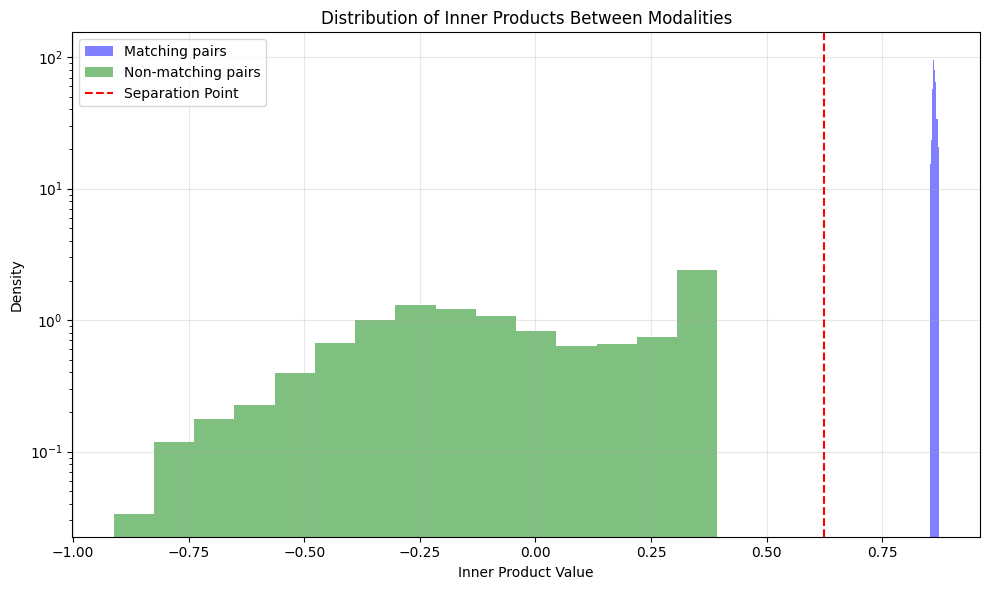

In [9]:
# Calculate all pairwise inner products between modalities
plt.figure(figsize=(10, 6))

# Collect all matching and non-matching pairs
all_matching_pairs = []
all_non_matching_pairs = []

for i in range(n_modalities):
    for j in range(i+1, n_modalities):
        inner_products = torch.matmul(final_vectors[i], final_vectors[j].t())
        
        # Get matching pairs (diagonal elements)
        matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
        all_matching_pairs.extend(matching_pairs)
        
        # Get non-matching pairs (off-diagonal elements)
        mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
        non_matching_pairs = inner_products[mask].detach().cpu().numpy()
        all_non_matching_pairs.extend(non_matching_pairs)

# Plot single histograms for all matching and non-matching pairs
plt.hist(all_matching_pairs, bins=15, alpha=0.5, 
        label='Matching pairs', color='blue', density=True, log=True)
plt.hist(all_non_matching_pairs, bins=15, alpha=0.5, 
        label='Non-matching pairs', color='green', density=True, log=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(all_matching_pairs)
max_non_matching = np.max(all_non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
plt.axvline(x=midpoint, color='red', linestyle='--', label='Separation Point')

plt.xlabel('Inner Product Value')
plt.ylabel('Density')
plt.title('Distribution of Inner Products Between Modalities')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
